# Experiment: Distributed Fold Pipeline - Online Classification

In this exemplary experiment we use float to compare three online classifiers with respect to different performance measures. We use a distributed fold evaluation strategy.

The distributed fold pipeline can be used similarly to the prequential pipeline. Hence, **for more detailed information, e.g. regarding feature selection, concept drift detection, or additional visualization options, please see one of the experiments for the prequential pipeline.**

In [1]:
# Optional: Rebase the file path.
# Note that you may also provide explicit file paths and avoid this step.
import os
os.chdir(os.getcwd()[:-18])

In [2]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import MinMaxScaler
from skmultiflow.trees import HoeffdingTreeClassifier, HoeffdingAdaptiveTreeClassifier
from river.linear_model import Perceptron, LogisticRegression

# Import float modules
from float.data import DataLoader
from float.data.preprocessing import SklearnScaler
from float.pipeline import DistributedFoldPipeline
from float.prediction.skmultiflow import SkmultiflowClassifier
from float.prediction.river import RiverClassifier
from float.prediction.evaluation import PredictionEvaluator
from float.prediction.evaluation.measures import noise_variability
import float.visualization as fvis

### Setup *float* modules

#### Create a DataLoader object
We load the Electricity data set and specify a sklearn MinMaxScaler for the normalization.

In [3]:
data_loader = DataLoader(path='float/data/datasets/electricity.csv',  # This path might have to be adjusted!
                         target_col=-1,
                         scaler=SklearnScaler(MinMaxScaler())
                         )

#### Create Predictor objects
We setup a list of predictors. Specifically, we want to compare models from skmultiflow and river. We use the default parameters of the packages, however, in general you can provide any configuration you like.

In [4]:
predictors = [SkmultiflowClassifier(model=HoeffdingAdaptiveTreeClassifier(), classes=data_loader.stream.target_values),
              SkmultiflowClassifier(model=HoeffdingTreeClassifier(), classes=data_loader.stream.target_values),
              RiverClassifier(model=LogisticRegression(), feature_names=data_loader.stream.feature_names)
              ]

#### Create a PredictorEvaluator object.
The evaluator will compute and store the performance measures when running the pipeline. Float automatically clones the provided evaluator for each specified predictor object. Indeed, since we use a distributed fold pipeline, float will maintain a dedicated evaluator for all parallel classifier instances.

Note you can hand any parameter of a measure function directly to the Evaluator, e.g. below we specify the zero_division parameter of the precision_score and the reference_measure and n_samples parameters of the noise_variability.

In [5]:
evaluator = PredictionEvaluator(measure_funcs=[accuracy_score, precision_score, noise_variability],
                                zero_division=0,
                                reference_measure=accuracy_score,
                                n_samples=15)

#### Create and run a DistributedFoldPipeline

We use a batch-incremental scheme, processing the data in batches of size 100. Moreover, we pretrain the classifiers on 200 observations and set a random state for reproducibility.

Note that we need to specify the **validation_mode** of the distributed fold pipeline. We can choose between 'cross', 'split' and 'bootstrap' as described in the corresponding paper by *Bifet et al. 2015. Efficient Online Evaluation of Big Data Stream Classifiers.* For illustration we use a 'bootstrap' validation.

In addition, we need to specify the **number of parallel instances** per predictor object. Here, we want to run 5 instances of each classifier.

In [6]:
pipeline = DistributedFoldPipeline(data_loader=data_loader,
                                   predictor=predictors,
                                   prediction_evaluator=evaluator,
                                   batch_size=100,
                                   n_pretrain=200,
                                   n_max=data_loader.stream.n_samples,  # We use all observations
                                   validation_mode='bootstrap',
                                   n_parallel_instances=5,
                                   random_state=0)

pipeline.run()

Pretrain the predictor with 200 observation(s).
[====================] 100%
################################## SUMMARY ##################################
Evaluation has finished after 112.41356325149536s
Data Set: float/data/datasets/electricity.csv
The DistributedFoldPipeline has processed 45312 instances, using batches of size 100.
-------------------------------------------------------------------------
*** Prediction ***
* Model No. 1: SkmultiflowClassifier.HoeffdingAdaptiveTreeClassifier (5 parallel instances)
| Performance Measure    |       Value |
|------------------------|-------------|
| Avg. Test Comp. Time   |  0.00289825 |
| Avg. Train Comp. Time  |  0.025093   |
| Avg. accuracy_score    |  0.734875   |
| Avg. precision_score   |  0.782786   |
| Avg. noise_variability | -0.257452   |
* Model No. 2: SkmultiflowClassifier.HoeffdingTreeClassifier (5 parallel instances)
| Performance Measure    |       Value |
|------------------------|-------------|
| Avg. Test Comp. Time   |

The summarized results suggest that the HoeffdingTree and the HoeffdingAdaptiveTree perform almost equivalently in terms of accuracy and precision. However, the HoeffdingTree has slight advantages w.r.t the noise variability. We may get further insight into the performance of the classifiers by using the visualization module of float.

### Visualizing Results

Float provides standardized plot types that may be used to illustrate results stored in an evaluator object. 
However, note that you can essentially do whatever you like with the evaluator object, e.g. save it or create custom tables.

The evaluator object contains all results, e.g. performance measures and computation times, that were calculated during the pipeline run. Since we trained 3 predictors with 5 instances each, the pipeline.prediction_evaluators object contains 3 lists of 5 evaluators each.

Since we ran multiple instances of each classifier, we can plot the mean and variance score obtained at each time step (Note that this is different from the decay or sliding window aggregations that we show in the classification experiment for the PrequentialPipeline).

/var/folders/xn/3jc7rv712sz4_dvzm09xl9j00000gn/T/ipykernel_33794/275933132.py:6: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(measure, axis=0)
/var/folders/xn/3jc7rv712sz4_dvzm09xl9j00000gn/T/ipykernel_33794/275933132.py:7: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = np.nanvar(measure, axis=0)


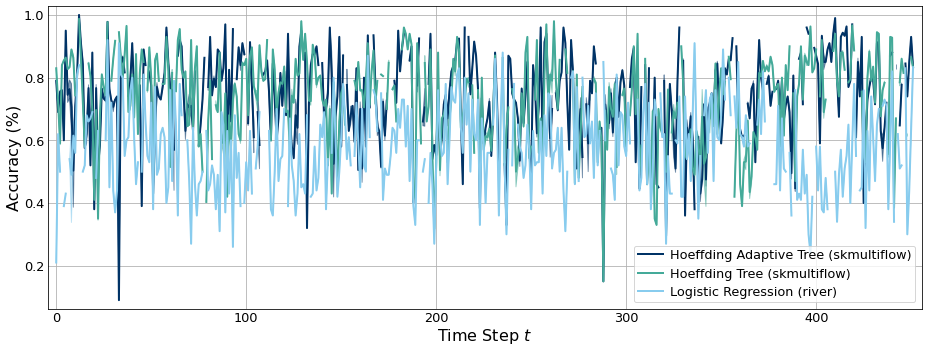

In [7]:
mean_measures = []
var_measures = []

for evaluator_list in pipeline.prediction_evaluators:
    measure = [eval_instance.result['accuracy_score']['measures'] for eval_instance in evaluator_list]
    mean = np.nanmean(measure, axis=0)
    var = np.nanvar(measure, axis=0)
    mean_measures.append(mean)
    var_measures.append(var)

ax = fvis.plot(measures=mean_measures,
               variance_measures=var_measures,
               legend_labels=['Hoeffding Adaptive Tree (skmultiflow)', 
                              'Hoeffding Tree (skmultiflow)', 
                              'Logistic Regression (river)'],
               y_label='Accuracy (%)')

plt.show()

Note that we can observe 'breaks' in the line plots. These corresond to time steps where none of the parallel classifier instances has been used for testing. This can happen in the bootstrap validation scheme as we randomly sample the classifier instances used for testing from a Poisson distribution.

As before, the Hoeffding Tree based classifiers outperform the LogisticRegression model. Notably, the variance between the parallel classifier instances is almost unrecognisable in this plot.

Finally, note that the distributed fold pipeline is the only evaluation strategy that allows us to identify significant differences via hypothesis testing (since we obtain multiple independent evaluations per predictor).